In [3]:
# first let's load in our dataset and see how we can split it up into two tensors of board state to move + win, each game we download
# should have around 40 moves in it (average game is 40 long), we will need a good mix of games as well as puzzles I feel for some
# tactical training, maybe some end games first

# first step is to download the dataset, will refine this more but for now we'll grab around 500mb of games from lichess 2015 - August
# first step will be to filter out all games lower than 1800 ELO and work with that

training_data_path = "./training_data/lichess_db_standard_rated_2015-08.pgn"

with open(training_data_path, 'r') as file:
    for i, line in enumerate(file):
        if i >= 200:
            break
        print(line.strip())

[Event "Rated Blitz tournament https://lichess.org/tournament/qg3Tx2iL"]
[Site "https://lichess.org/FnlPcwBr"]
[White "paul2chess3"]
[Black "Andique"]
[Result "1-0"]
[UTCDate "2015.07.31"]
[UTCTime "22:00:01"]
[WhiteElo "1509"]
[BlackElo "1623"]
[WhiteRatingDiff "+15"]
[BlackRatingDiff "-16"]
[ECO "C62"]
[Opening "Ruy Lopez: Steinitz Defense"]
[TimeControl "300+0"]
[Termination "Normal"]

1. e4 e5 2. Nf3 Nc6 3. Bb5 d6 4. d4 exd4 5. Nxd4 Bd7 6. Nxc6 Bxc6 7. Bxc6+ bxc6 8. O-O Be7 9. c4 Nf6 10. Nc3 O-O 11. Re1 h6 12. Be3 Re8 13. b3 Ng4 14. Bc1 Bf6 15. Bb2 d5 16. Qxg4 d4 17. Ne2 c5 18. Ng3 d3 19. Bxf6 Qxf6 20. Rad1 Qc3 21. Nf5 Rad8 22. Nxh6+ Kh7 23. Nf5 d2 24. Re3 Qf6 25. Rh3+ Kg8 26. Qh5 g6 27. Qh7+ Kf8 28. Qh8+ Qxh8 29. Rxh8# 1-0

[Event "Rated Blitz tournament https://lichess.org/tournament/lbY5qfF4"]
[Site "https://lichess.org/iXXxIHPA"]
[White "Shehewho"]
[Black "gentux"]
[Result "1-0"]
[UTCDate "2015.07.31"]
[UTCTime "22:00:01"]
[WhiteElo "1857"]
[BlackElo "1963"]
[WhiteRatingDiff "+

In [7]:
import chess.pgn
import io

def filter_pgn_by_elo(input_file, output_file, min_elo, max_games=None):
    games_written = 0
    
    with open(input_file, 'r') as pgn_input, open(output_file, 'w') as pgn_output:
        while True:
            game = chess.pgn.read_game(pgn_input)
            if game is None:
                break
            
            white_elo = game.headers.get("WhiteElo", "0")
            black_elo = game.headers.get("BlackElo", "0")
            
            if white_elo.isdigit() and black_elo.isdigit():
                if int(white_elo) >= min_elo and int(black_elo) >= min_elo:
                    # Create a new game with only the desired headers
                    new_game = chess.pgn.Game()
                    new_game.headers["WhiteElo"] = white_elo
                    new_game.headers["BlackElo"] = black_elo
                    new_game.headers["Result"] = game.headers.get("Result", "*")
                    
                    # Copy the moves
                    node = new_game
                    for move in game.mainline_moves():
                        node = node.add_variation(move)
                    
                    pgn_output.write(str(new_game) + "\n\n")
                    games_written += 1
                    
                    if games_written % 100 == 0:
                        print(f"Processed {games_written} games")
                    
                    if max_games is not None and games_written >= max_games:
                        break
    
    print(f"Total games written: {games_written}")
    return games_written
    
max_games = 5000
input_file = training_data_path
output_file = "./training_data/filtered_dataset_2000_elo.pgn"
min_elo = 2000

# total_games = filter_pgn_by_elo(input_file, output_file, min_elo, max_games)

Processed 100 games
Processed 200 games
Processed 300 games
Processed 400 games
Processed 500 games
Processed 600 games
Processed 700 games
Processed 800 games
Processed 900 games
Processed 1000 games
Processed 1100 games
Processed 1200 games
Processed 1300 games
Processed 1400 games
Processed 1500 games
Processed 1600 games
Processed 1700 games
Processed 1800 games
Processed 1900 games
Processed 2000 games
Processed 2100 games
Processed 2200 games
Processed 2300 games
Processed 2400 games
Processed 2500 games
Processed 2600 games
Processed 2700 games
Processed 2800 games
Processed 2900 games
Processed 3000 games
Processed 3100 games
Processed 3200 games
Processed 3300 games
Processed 3400 games
Processed 3500 games
Processed 3600 games
Processed 3700 games
Processed 3800 games
Processed 3900 games
Processed 4000 games
Processed 4100 games
Processed 4200 games
Processed 4300 games
Processed 4400 games
Processed 4500 games
Processed 4600 games
Processed 4700 games
Processed 4800 games
P

In [8]:
# ended up terminating it after 5000 games, that should be way more than enough for initial training

Total Games: 5000
Average Move Count: 75.38
Average White Elo: 2144.89
Average Black Elo: 2144.50
White Wins: 2420
Black Wins: 2211
Draws: 369


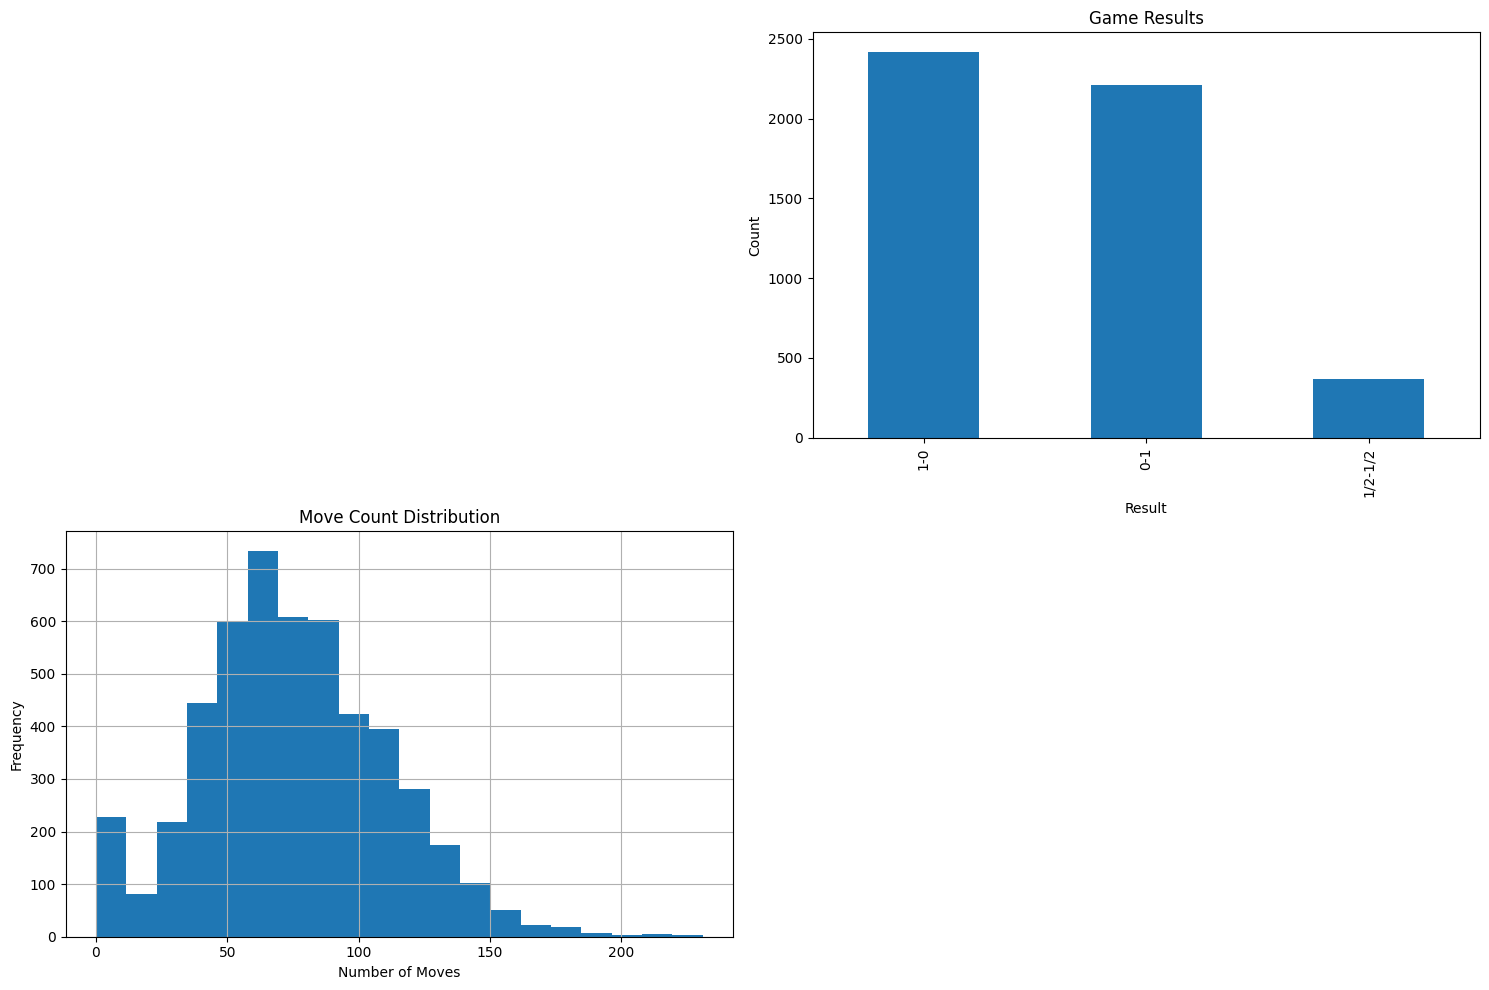

In [11]:
import chess.pgn
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def analyze_pgn(file_path):
    games_data = []
    
    with open(file_path, 'r') as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            
            white_elo = int(game.headers.get("WhiteElo", 0))
            black_elo = int(game.headers.get("BlackElo", 0))
            result = game.headers.get("Result", "*")
            move_count = len(list(game.mainline_moves()))
            
            games_data.append({
                "WhiteElo": white_elo,
                "BlackElo": black_elo,
                "Result": result,
                "MoveCount": move_count
            })
    
    return pd.DataFrame(games_data)

def generate_stats_and_charts(df):
    # Basic statistics
    total_games = len(df)
    avg_move_count = df['MoveCount'].mean()
    avg_white_elo = df['WhiteElo'].mean()
    avg_black_elo = df['BlackElo'].mean()
    
    result_counts = df['Result'].value_counts()
    white_wins = result_counts.get('1-0', 0)
    black_wins = result_counts.get('0-1', 0)
    draws = result_counts.get('1/2-1/2', 0)
    
    print(f"Total Games: {total_games}")
    print(f"Average Move Count: {avg_move_count:.2f}")
    print(f"Average White Elo: {avg_white_elo:.2f}")
    print(f"Average Black Elo: {avg_black_elo:.2f}")
    print(f"White Wins: {white_wins}")
    print(f"Black Wins: {black_wins}")
    print(f"Draws: {draws}")
    
    # Charts
    plt.figure(figsize=(15, 10))
    
    # Game Results
    plt.subplot(2, 2, 2)
    result_counts.plot(kind='bar')
    plt.title('Game Results')
    plt.xlabel('Result')
    plt.ylabel('Count')
    
    # Move Count Distribution
    plt.subplot(2, 2, 3)
    df['MoveCount'].hist(bins=20)
    plt.title('Move Count Distribution')
    plt.xlabel('Number of Moves')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

df = analyze_pgn(output_file)
generate_stats_and_charts(df)

In [ ]:
# note, we might need to filter down the games with very low move counts because those could be time things or forfeits
# also maybe filter out the very long games? not sure

In [34]:
# claude helper method to represent a move

import numpy as np

def represent_move(move, board):
    # Standard algebraic notation (SAN)
    san = board.san(move)
    
    # UCI (Universal Chess Interface) notation
    uci = move.uci()
    
    # From and To squares as integers (0-63)
    from_square = move.from_square
    to_square = move.to_square
    
    # From and To squares as coordinates (e.g., 'e2', 'e4')
    from_coord = chess.SQUARE_NAMES[from_square]
    to_coord = chess.SQUARE_NAMES[to_square]
    
    # One-hot encoded move (8x8x73 tensor)
    one_hot = np.zeros((8, 8, 73), dtype=np.uint8)
    from_rank, from_file = divmod(from_square, 8)
    to_rank, to_file = divmod(to_square, 8)
    one_hot[from_rank, from_file, to_rank * 8 + to_file] = 1
    if move.promotion:
        one_hot[to_rank, to_file, 64 + move.promotion - 2] = 1
    
    return {
        'san': san,
        'uci': uci,
        'from_square': from_square,
        'to_square': to_square,
        'from_coord': from_coord,
        'to_coord': to_coord,
        'one_hot': one_hot
    }

In [36]:
# let's load in a filtered set of maybe 100 games (7500k examples with average 75 moves) into memory, will need to also write a script
# that processes the game board state (maybe with python chess?) into the tensor type and then run that on all of our filtered
# game dataset
import chess
import chess.pgn


pgn = open(output_file)
first_game = chess.pgn.read_game(pgn)
board = chess.Board()
print(board)

for move in first_game.mainline_moves():
    representations = represent_move(move, board)
    board.push(move)
    
    print(f"Move: {representations['san']}")
    print(f"UCI: {representations['uci']}")
    print(f"From-To (coord): {representations['from_coord']} -> {representations['to_coord']}")
    print("One-hot shape:", representations['one_hot'].shape)
    print(board)
    print()
    
# start with loading in 1 game and breaking it down move by move into the training examples
# need to define the input shape and output shape

# each plane is 8 x 8 for simplicity

# we have the following planes / shape
# channel_length_time_tracked = 6 (white pieces) + 6 (black pieces) + 2 (all 0s, 1s, 2s or 3s for repetition count for white and black) = 14
# channel_length_current_turn_only = 1 (who's turn is it 0 for white 1 for black) + 1 (total move count, all ints representing move count)
# + 4 (can or cannot king and queen side castle for white and black, 1 for can, 0 for cannot)+ 1 for no progress count
# (no progress count is number of moves made since the last pawn move or piece capture) = 7

# batch_size, (time_steps * channel_length_time_tracked (14)) + channel_length_current_turn_only (7), 8 x 8 to represent board
# for example with batch_size 32 and 8 time steps (hyper params I think we'll determine)
# we get 7616 per batch * 32 = 243,712

# now let's think about and understand the output

# we need to map each board state as a prediction of the output value and maximize that probability
# we'll have 4672 possible outputs according to the paper, each of these will correspond to a possible move, then we want to minimize
# the loss between our network outputted probability and the label

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Move: d4
UCI: d2d4
From-To (coord): d2 -> d4
One-hot shape: (8, 8, 73)
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R

Move: Nf6
UCI: g8f6
From-To (coord): g8 -> f6
One-hot shape: (8, 8, 73)
r n b q k b . r
p p p p p p p p
. . . . . n . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R

Move: c4
UCI: c2c4
From-To (coord): c2 -> c4
One-hot shape: (8, 8, 73)
r n b q k b . r
p p p p p p p p
. . . . . n . .
. . . . . . . .
. . P P . . . .
. . . . . . . .
P P . . P P P P
R N B Q K B N R

Move: e6
UCI: e7e6
From-To (coord): e7 -> e6
One-hot shape: (8, 8, 73)
r n b q k b . r
p p p p . p p p
. . . . p n . .
. . . . . . . .
. . P P . . . .
. . . . . . . .
P P . . P P P P
R N B Q K B N R

Move: Nf3
UCI: g1f3
From-To (coord): g1 -> f3
One-hot shape: (8, 8, 73)

In [ ]:
# then let's load in torch and see how we can represent the games based on alphazero paper, hard part will be mapping enpessant
# castling and all of those rules